In [ ]:
! pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt

### Read files and get required columns

In [ ]:
data = pd.read_csv('/content/us_state_vaccinations.csv')
population_data = pd.read_csv('/content/csvData.csv')

In [ ]:
data.head(2)

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222


In [ ]:
population = population_data[['State', 'Pop']]
population.head()
state_pop = population['Pop'].iloc[0]
state_pop

39613500

In [ ]:
california = data[data['location'] == 'California']
california.shape

(93, 14)

In [ ]:
california['date'] = pd.to_datetime(california['date'])
california.set_index('date', inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
california2 = california[['people_fully_vaccinated']]
california2

,people_fully_vaccinated
date,
2021-01-12,100089.0
2021-01-13,133689.0
2021-01-14,NaN
2021-01-15,204374.0
2021-01-16,NaN
...,...
2021-04-10,8110488.0
2021-04-11,8332396.0
2021-04-12,8459357.0


In [ ]:
california3 = california2.dropna()
california3['people_fully_vaccinated'].unique()
california3['people_fully_vaccinated'].astype(int)

date
2021-01-12     100089
2021-01-13     133689
2021-01-15     204374
2021-01-19     260838
2021-01-20     273276
               ...   
2021-04-10    8110488
2021-04-11    8332396
2021-04-12    8459357
2021-04-13    8553174
2021-04-14    8696655
Name: people_fully_vaccinated, Length: 88, dtype: int64

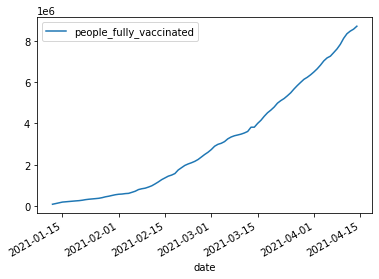

In [ ]:
california3.plot()

In [ ]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(california3)

(0.9291489706807239, True)

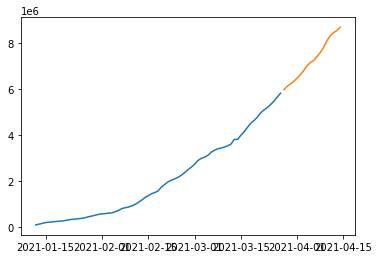

In [ ]:
train = california3[:70]
test = california3[-18:]
plt.plot(train)
plt.plot(test)

### Build model

In [ ]:
arima_model = auto_arima(train)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -818.396
Date:                Thu, 15 Apr 2021   AIC                           1640.791
Time:                        04:59:37   BIC                           1645.230
Sample:                             0   HQIC                          1642.550
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6946      0.080     -8.726      0.000      -0.851      -0.539
sigma2      1.765e+09   8.19e-12   2.16e+20      0.000    1.77e+09    1.77e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 9.31
Prob(Q):                              0.88   Prob(JB):                         0.01
Heteroskedasticity (H):               7.87   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+36. Standard errors may be unstable.
"""

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 18), index = test.index)
prediction.columns = ['predicted total num of vaccination']
prediction['predicted total num of vaccination'] = round(prediction['predicted total num of vaccination']).astype(int)
prediction

,predicted total num of vaccination
date,
2021-03-28,5986427
2021-03-29,6141951
2021-03-30,6297476
2021-03-31,6453000
2021-04-01,6608525
2021-04-02,6764049
2021-04-03,6919574
2021-04-04,7075098
2021-04-05,7230623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Unrecognized location 'left corner'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  """


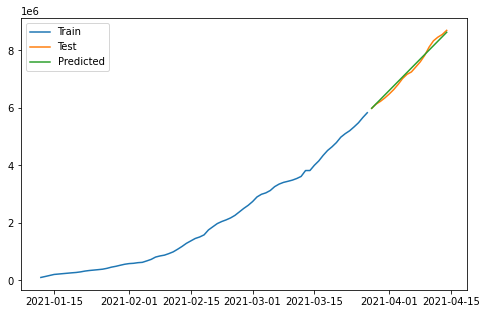

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(prediction, label="Predicted")
plt.legend(loc='left corner')
plt.show()

In [ ]:
from sklearn.metrics import r2_score
test['predicted total num of vaccination'] = prediction
r2_score(test['people_fully_vaccinated'], test['predicted total num of vaccination'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.986943982999919

In [ ]:
print(np.sqrt(metrics.mean_squared_error(test['people_fully_vaccinated'],prediction['predicted total num of vaccination'])))

99125.79665253642
